In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns",
              None, 'display.max_colwidth', None)

from matplotlib import pyplot as plt
import numpy as np
import os


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [2]:
path_dataset = os.path.join(os.path.dirname(os.getcwd()), 'Dataset')
path_result = os.path.join(os.path.dirname(os.getcwd()), 'Result')

path_challenge = os.path.join(path_result, 'Challenge')
path_solution = os.path.join(path_result, 'Solution')

path_challenge_evolution = os.path.join(path_challenge, 'Evolution')
if not os.path.exists(path_challenge_evolution):
   os.makedirs(path_challenge_evolution)

path_solution_evolution = os.path.join(path_solution, 'Evolution')
if not os.path.exists(path_solution_evolution):
   os.makedirs(path_solution_evolution)

In [9]:
# combine issues and questions

df_issues = pd.read_json(os.path.join(path_dataset, 'issues.json'))
df_questions = pd.read_json(os.path.join(path_dataset, 'questions.json'))

df_issues['Challenge_link'] = df_issues['Issue_link']
df_issues['Challenge_original_content'] = df_issues['Issue_original_content']
df_issues['Challenge_preprocessed_content'] = df_issues['Issue_preprocessed_content']
df_issues['Challenge_summary'] = df_issues['Issue_gpt_summary']
df_issues['Challenge_creation_time'] = df_issues['Issue_creation_time']
df_issues['Challenge_comment_count'] = df_issues['Issue_comment_count']
df_issues['Challenge_score'] = df_issues['Issue_upvote_count'] - df_issues['Issue_downvote_count']
df_issues['Challenge_closed_time'] = df_issues['Issue_closed_time']
df_issues['Solution_summary'] = df_issues['Fix_manual_summary']

df_questions['Challenge_link'] = df_questions['Question_link']
df_questions['Challenge_original_content'] = df_questions['Question_original_content']
df_questions['Challenge_preprocessed_content'] = df_questions['Question_preprocessed_content']
df_questions['Challenge_summary'] = df_questions['Question_gpt_summary']
df_questions['Challenge_creation_time'] = df_questions['Question_creation_time']
df_questions['Challenge_comment_count'] = df_questions['Question_comment_count']
df_questions['Challenge_score'] = df_questions['Question_score']
df_questions['Challenge_closed_time'] = df_questions['Question_closed_time']
df_questions['Solution_original_content'] = df_questions['Answer_original_content']
df_questions['Solution_preprocessed_content'] = df_questions['Answer_preprocessed_content']
df_questions['Solution_summary'] = df_questions['Answer_gpt_summary']

del df_issues['Issue_title']
del df_issues['Issue_body']
del df_issues['Issue_link']
del df_issues['Issue_creation_time']
del df_issues['Issue_comment_count']
del df_issues['Issue_upvote_count']
del df_issues['Issue_downvote_count']
del df_issues['Issue_original_content']
del df_issues['Issue_preprocessed_content']
del df_issues['Issue_gpt_summary_original']
del df_issues['Issue_gpt_summary']
del df_issues['Issue_closed_time']
del df_issues['Fix_manual_summary_original']
del df_issues['Fix_manual_summary']

del df_questions['Question_title']
del df_questions['Question_body']
del df_questions['Question_link']
del df_questions['Question_creation_time']
del df_questions['Question_comment_count']
del df_questions['Question_score']
del df_questions['Question_original_content']
del df_questions['Question_preprocessed_content']
del df_questions['Question_gpt_summary_original']
del df_questions['Question_gpt_summary']
del df_questions['Question_closed_time']
del df_questions['Answer_original_content']
del df_questions['Answer_preprocessed_content']
del df_questions['Answer_gpt_summary_original']
del df_questions['Answer_gpt_summary']

df_all = pd.concat([df_issues, df_questions], ignore_index=True)
df_all.to_json(os.path.join(path_dataset, 'original.json'),
               indent=4, orient='records')

In [10]:
# remove custom stop words from challenges and solutions

from gensim.parsing.preprocessing import remove_stopwords

stop_words_custom = [
    'amazon',
    'answer',
    'appreci',
    'attempt',
    'azur',
    'challeng',
    'deep learn',
    'differ',
    'difficulti',
    'encount',
    'error',
    'experi',
    'databrick',
    'face',
    'fix',
    'googl',
    'hei',
    'hello',
    'help',
    'includ',
    'issu',
    'look',
    'machin learn',
    'microsoft',
    'need',
    'possibl',
    'problem',
    'project',
    'provid',
    'python',
    'pytorch',
    'question',
    'resolv',
    'respond',
    'seek',
    'solut',
    'solv',
    'struggl',
    'suggest',
    'tensorflow',
    'thank',
    'try',
    'unabl',
    'user'
]

df_all = pd.read_json(os.path.join(path_dataset, 'original.json'))

for index, row in df_all.iterrows():
    df_all.at[index, 'Challenge_original_content'] = remove_stopwords(row['Challenge_original_content'].replace(
        'Title: ', '').replace('Answer: ', ''), stopwords=stop_words_custom)
    df_all.at[index, 'Challenge_preprocessed_content'] = remove_stopwords(
        row['Challenge_preprocessed_content'].replace('Title: ', '').replace('Answer: ', ''), stopwords=stop_words_custom)
    df_all.at[index, 'Challenge_summary'] = remove_stopwords(row['Challenge_summary'], stopwords=stop_words_custom)

    if row['Solution_original_content']:
        df_all.at[index, 'Solution_original_content'] = remove_stopwords(row['Solution_original_content'].replace(
            'Title: ', '').replace('Answer: ', ''), stopwords=stop_words_custom)
        df_all.at[index, 'Solution_preprocessed_content'] = remove_stopwords(
            row['Solution_preprocessed_content'].replace('Title: ', '').replace('Answer: ', ''), stopwords=stop_words_custom)
        df_all.at[index, 'Solution_summary'] = remove_stopwords(row['Solution_summary'], stopwords=stop_words_custom)

df_all.to_json(os.path.join(path_dataset, 'preprocessed.json'),
               indent=4, orient='records')

In [11]:
df_all = pd.read_json(os.path.join(path_dataset, 'preprocessed.json'))

# remove issues with uninformed content
for index, row in df_all.iterrows():
    if len(row['Challenge_original_content'].split()) < 6 or len(row['Challenge_original_content']) < 30:
        print(row['Challenge_original_content'])
        df_all.drop(index, inplace=True)
    elif row['Solution_original_content'] and (len(row['Solution_original_content'].split()) < 6 or len(row['Solution_original_content']) < 30):
        print(row['Solution_original_content'])
        df_all.drop(index, inplace=True)

df_all.to_json(os.path.join(path_dataset, 'filtered.json'),
               indent=4, orient='records')

wonder initi studio lab titl
modulenotfounderror modul tensorboard
combin param param work
access allow access member given
load
deploy fail
log val loss
import
tensorboard default logger option
logger
run end run finish creat
vpc endpoint api api st
support hive adl
cloudform templat sure
csv file folder recordio
littl involv ye
file pin azurestor
processingstep uri code locat refer
leav case come accross
pipelin moment
aw cli aw sdk exampl
let know happen
delet creat endpoint
report appear bug team investig
code work
like templat run creat instanc
passau refer visual studio magazin
bug got correct todai close
upgrad sqlalchemi
file path ensur correct path
tri work let file transient
think chang log stream servic
situat chang git avail
sdk support automl sdk support
actual come smdebug version downgrad
updat core
forc gpu devic devic gpu
begin list
accord document maximum
sure estim framework version version
web termin import delet
ye maxtrialscallback exact featur situat
add run flus

In [4]:
df_all = pd.read_json(os.path.join(path_dataset, 'topics.json'))

df_challenge = df_all.groupby('Challenge_topic').agg(Mean_score=('Challenge_score', 'mean'), Mean_comments=('Challenge_comment_count', 'mean'), Count = ('Challenge_topic', 'count')).reset_index().round(2)
df_challenge['Score_comment_ratio'] = (df_challenge['Mean_score'] / df_challenge['Mean_comments']).round(2)
df_challenge = df_challenge.sort_values('Score_comment_ratio', ascending=False)
df_challenge.set_index('Challenge_topic')


,Mean_score,Mean_comments,Count,Score_comment_ratio
Challenge_topic,,,,
50,0.56,0.00,9,inf
31,0.56,0.00,73,inf
47,1.61,0.00,49,inf
45,0.78,0.00,40,inf
7,1.12,0.30,68,3.73
10,2.32,0.78,104,2.97
11,1.61,0.56,100,2.88
18,2.03,0.75,78,2.71
9,1.19,0.55,58,2.16


<Axes: title={'center': 'Challenge topics'}>

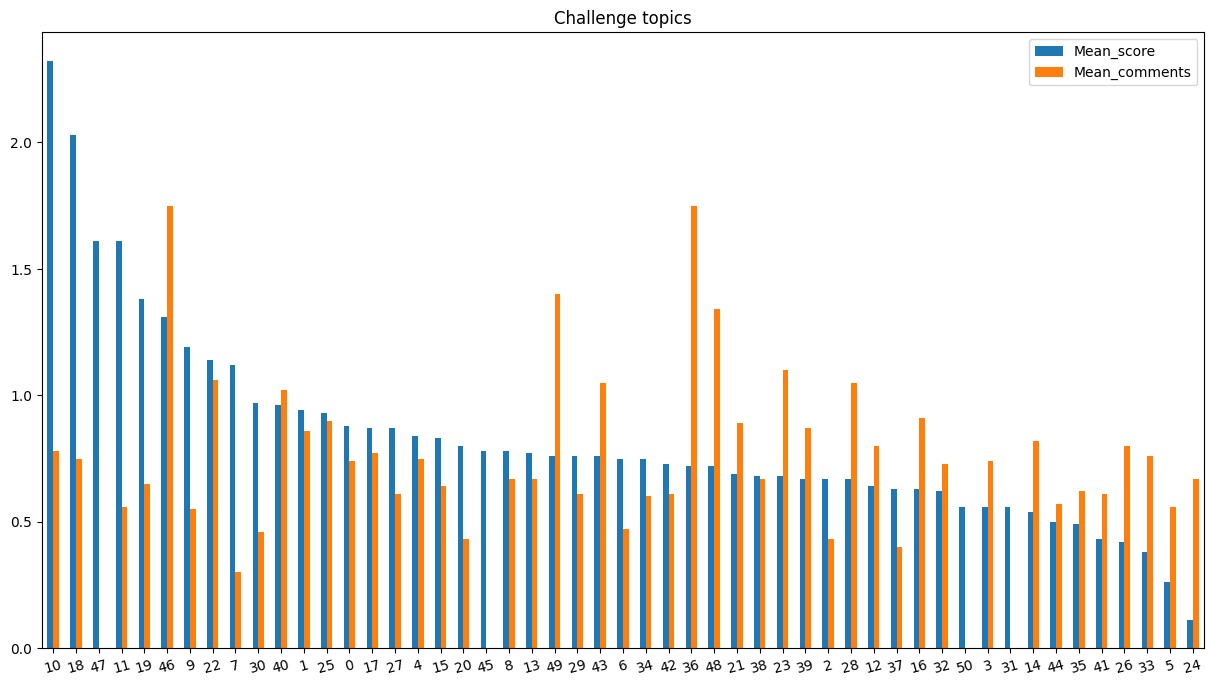

In [7]:
df_challenge = df_challenge.sort_values('Mean_score', ascending=False)
df_challenge[['Mean_score', 'Mean_comments']].plot(kind='bar', figsize=(15, 8), title='Challenge topics', rot=15)

In [73]:
df_all = pd.read_json(os.path.join(path_dataset, 'topics.json'))
# BigQuery Stack Overflow public dataset is updated until Nov 24, 2022, 1:39:22 PM UTC-5
min(df_all['Challenge_creation_time']), max(df_all['Challenge_creation_time'])

(Timestamp('2014-09-14 22:12:24.493000'),
 Timestamp('2023-02-21 18:36:06.284000'))

In [72]:
import scipy.interpolate
from statsmodels.nonparametric.smoothers_lowess import lowess as sm_lowess

def smooth(x, y, xgrid, lowess_kw=None):
    samples = np.random.choice(len(x), 50, replace=True)
    y_s = y[samples]
    x_s = x[samples]
    y_sm = sm_lowess(y_s, x_s, **lowess_kw)
    # regularly sample it onto the grid
    y_grid = scipy.interpolate.interp1d(x_s, y_sm, fill_value='extrapolate')(xgrid)
    return y_grid

def lowess_with_confidence_bounds(x, y, conf_interval=0.95, lowess_kw=None):
    """
    Perform Lowess regression and determine a confidence interval by bootstrap resampling
    """
    xgrid = np.linspace(x.min(),x.max())
    
    K = 100
    smooths = np.stack([smooth(x, y, xgrid, lowess_kw) for _ in range(K)]).T

    mean = np.nanmean(smooths, axis=1)
    stderr = scipy.stats.sem(smooths, axis=1)
    
    clower = np.nanpercentile(smooths, (1-conf_interval)*50, axis=1)
    cupper = np.nanpercentile(smooths, (1+conf_interval)*50, axis=1)
    
    return xgrid, mean, stderr, clower, cupper

In [71]:
# Explore challenge topics evolution

df_all = pd.read_json(os.path.join(path_dataset, 'topics.json'))
df_challenge = df_all[(df_all['Challenge_creation_time'] > '2014-09-14') & (df_all['Challenge_creation_time'] < '2022-11-21')]
i=0
for name, group in df_challenge.groupby('Challenge_topic'):
    group = group.groupby(pd.Grouper(key='Challenge_creation_time', freq='2W')).agg(Count = ('Challenge_topic', 'count')).reset_index()
    
    x=pd.to_datetime(group['Challenge_creation_time']).values
    x=np.array([i.astype('datetime64[D]').astype(int) for i in x])
    y=group['Count'].values
    
    # 95% confidence interval
    xgrid, mean, stderr, clower, cupper = lowess_with_confidence_bounds(x, y, conf_interval=0.95, lowess_kw={"frac": 0.5, "it": 5, "return_sorted": False})
    
    x=pd.to_datetime(group['Challenge_creation_time']).values
    fig, ax = plt.subplots()
    plt.plot(x, y, 'k.', label='Observations')
    plt.plot(xgrid, mean, color='tomato', label='LOWESS')
    plt.fill_between(xgrid, clower, cupper, alpha=0.3, label='LOWESS uncertainty')
    plt.legend(loc='best')
    fig.savefig(os.path.join(path_challenge_evolution, f'Topic_{name}'), bbox_inches="tight")
    plt.close()



In [75]:
df_all = pd.read_json(os.path.join(path_dataset, 'topics.json'))
df_solution = df_all[df_all['Solution_topic'] > -1]
# BigQuery Stack Overflow public dataset is updated until Nov 24, 2022, 1:39:22 PM UTC-5
min(df_solution['Challenge_creation_time']), max(df_solution['Challenge_creation_time'])

(Timestamp('2014-09-14 22:12:24.493000'),
 Timestamp('2023-02-21 18:36:06.284000'))

In [ ]:
# Explore solution topics evolution

df_all = pd.read_json(os.path.join(path_dataset, 'topics.json'))
df_solution = df_all[df_all['Solution_topic'] > -1]
df_solution = df_solution[df_solution['Challenge_creation_time'] < '2022-11-21']

for name, group in df_solution.groupby('Challenge_topic'):
    group = group.groupby(pd.Grouper(key='Solution_creation_time', freq='W')).agg(Count = ('Challenge_topic', 'count')).reset_index()
    fig = plt.figure()
    axis = fig.add_subplot(111)
    group.plot(x='Solution_creation_time',y='Count',ax=axis, grid=True, color='red')
    axis.axes.get_xaxis().get_label().set_visible(False) 
    axis.set_ylabel('Topic evolution', fontsize=20)
    plt.title(str(name), fontsize=30)
    fig.autofmt_xdate()
    fig.savefig(os.path.join(path_solution_evolution, f'Topic_{name}'), bbox_inches="tight")
    plt.close()


In [ ]:
# average answer time
df_all['Answer_time'] = df_all['Solution_creation_time'] - df_all['Challenge_creation_time']